In [15]:
import xarray as xr
import numpy as np
import scipy.stats as stats
from scipy.ndimage import gaussian_filter, uniform_filter

from scores.probability import crps_for_ensemble, tail_twcrps_for_ensemble
from scores.continuous import mse

from scores.processing import broadcast_and_match_nan
import matplotlib.pyplot as plt

np.random.seed(100)

In [16]:
X_LEN = 100
Y_LEN = 100

NEIGHBORHOOD = 5

NOISY_CONVECTION_VMAX = 30
BLOB_CONVECTION_VMAX = 40


def create_neighourhood_ensemble(fcst, neighborhood, remove_incomplete_ens=True):
    ensemble = fcst.rolling(
        dim=dict(x=neighborhood, y=neighborhood), center=True
    ).construct(x="i", y="j")
    ensemble = ensemble.stack(ens_mem=("i", "j"))
    if remove_incomplete_ens:
        ensemble = ensemble.where(~np.isnan(ensemble).any(dim="ens_mem"), np.nan)
    # Clean up coordinates for crps calculation
    ensemble = ensemble.drop_vars("ens_mem")
    ensemble = ensemble.assign_coords(ens_mem=np.arange(neighborhood**2))
    return ensemble

# Noisy convection

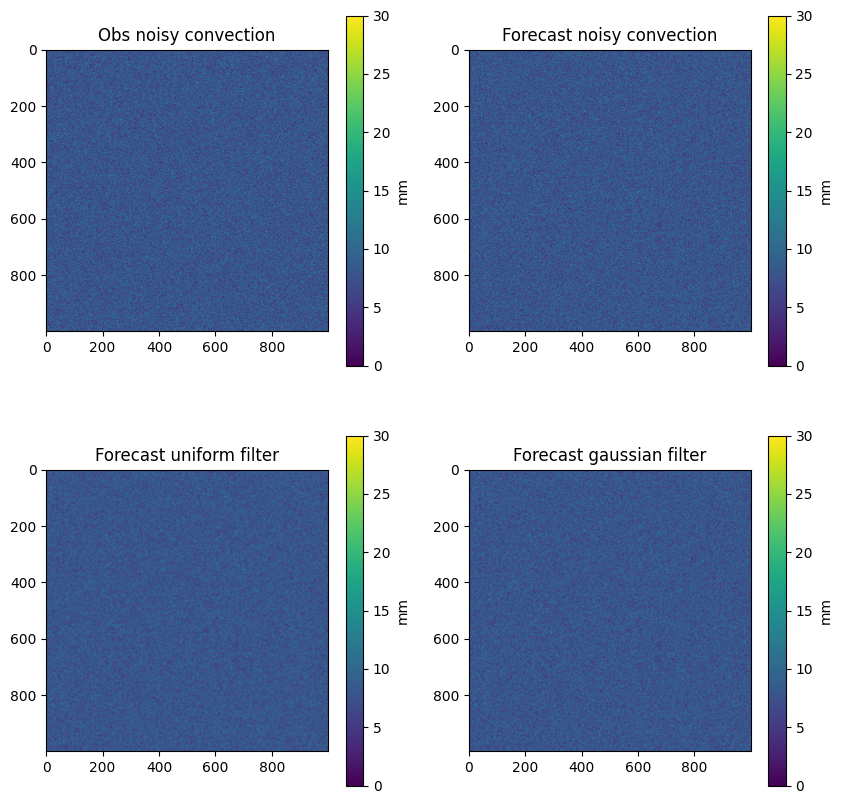

In [17]:
# Generate random values from a skew normal distribution
obs_convection = stats.skewnorm.rvs(a=10, scale=10, size=(Y_LEN, X_LEN)).clip(min=0)
obs_convection = xr.DataArray(
    obs_convection,
    dims=("y", "x"),
    coords={"x": np.arange(X_LEN), "y": np.arange(Y_LEN)},
)

fcst_convection = stats.skewnorm.rvs(a=10, scale=10, size=(Y_LEN, X_LEN)).clip(min=0)
fcst_convection = xr.DataArray(
    fcst_convection,
    dims=("y", "x"),
    coords={"x": np.arange(X_LEN), "y": np.arange(Y_LEN)},
)

fcst_clim = data = np.full((Y_LEN, X_LEN), obs_convection.mean().values)
fcst_clim = xr.DataArray(
    fcst_clim, dims=("y", "x"), coords={"x": np.arange(X_LEN), "y": np.arange(Y_LEN)}
)
fcst_uniform_filter = xr.apply_ufunc(
    uniform_filter, fcst_convection, kwargs=dict(size=NEIGHBORHOOD)
)
fcst_gaussian_filter = xr.apply_ufunc(
    gaussian_filter, fcst_convection, kwargs=dict(sigma=1)
)

# Visualise data (before ensemble creation)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot obs_convection
im1 = axs[0, 0].imshow(obs_convection, vmin=0, vmax=NOISY_CONVECTION_VMAX)
axs[0, 0].set_title("Obs noisy convection")

# Plot fcst_convection
im2 = axs[0, 1].imshow(fcst_convection, vmin=0, vmax=NOISY_CONVECTION_VMAX)
axs[0, 1].set_title("Forecast noisy convection")

# Plot fcst neighbourhood mean
im3 = axs[1, 0].imshow(fcst_uniform_filter, vmin=0, vmax=NOISY_CONVECTION_VMAX)
axs[1, 0].set_title("Forecast uniform filter")

# Plot fcst gaussian filter
im4 = axs[1, 1].imshow(fcst_gaussian_filter, vmin=0, vmax=NOISY_CONVECTION_VMAX)
axs[1, 1].set_title("Forecast gaussian filter")

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0], label="mm")
fig.colorbar(im2, ax=axs[0, 1], label="mm")
fig.colorbar(im3, ax=axs[1, 0], label="mm")
fig.colorbar(im4, ax=axs[1, 1], label="mm")

plt.show()

In [18]:
# Create ensembles
fcst_conv_ens = create_neighourhood_ensemble(fcst_convection, NEIGHBORHOOD)
fcst_clim_ens = create_neighourhood_ensemble(fcst_clim, NEIGHBORHOOD)
fcst_uniform_filter_ens = create_neighourhood_ensemble(
    fcst_uniform_filter, NEIGHBORHOOD
)
fcst_gaussian_filter_ens = create_neighourhood_ensemble(
    fcst_gaussian_filter, NEIGHBORHOOD
)

In [19]:
crps_noisy_conv = crps_for_ensemble(
    fcst_conv_ens, obs_convection, ensemble_member_dim="ens_mem"
).values
crps_clim_mean = crps_for_ensemble(
    fcst_clim_ens, obs_convection, ensemble_member_dim="ens_mem"
).values
crps_uniform_filter = crps_for_ensemble(
    fcst_uniform_filter_ens, obs_convection, ensemble_member_dim="ens_mem"
).values
crps_gaussian_filter = crps_for_ensemble(
    fcst_gaussian_filter_ens, obs_convection, ensemble_member_dim="ens_mem"
).values

print(f"CRPS for noisy convection: {crps_noisy_conv}")
print(f"CRPS for climatology: {crps_clim_mean}")
print(f"CRPS for uniform mean: {crps_uniform_filter}")
print(f"CRPS for gaussian mean: {crps_gaussian_filter}")

mse_noisy_conv = mse(fcst_convection, obs_convection).values
mse_clim_mean = mse(fcst_clim, obs_convection).values
mse_uniform_filter = mse(fcst_uniform_filter, obs_convection).values
mse_gaussian_filter = mse(fcst_gaussian_filter, obs_convection).values
print(f"MSE for noisy convection: {mse_noisy_conv}")
print(f"MSE for climatology: {mse_clim_mean}")
print(f"MSE for uniform filter: {mse_uniform_filter}")
print(f"MSE for gaussian filter: {mse_gaussian_filter}")

CRPS for noisy convection: 3.448497499115179
CRPS for climatology: 4.834396921288254
CRPS for uniform mean: 4.4405817042181965
CRPS for gaussian mean: 4.23680252307908
MSE for noisy convection: 73.15702817659648
MSE for climatology: 36.47766561828479
MSE for uniform filter: 37.93873159631427
MSE for gaussian filter: 39.3933797686508


# Blobby convection that is stronger in the east

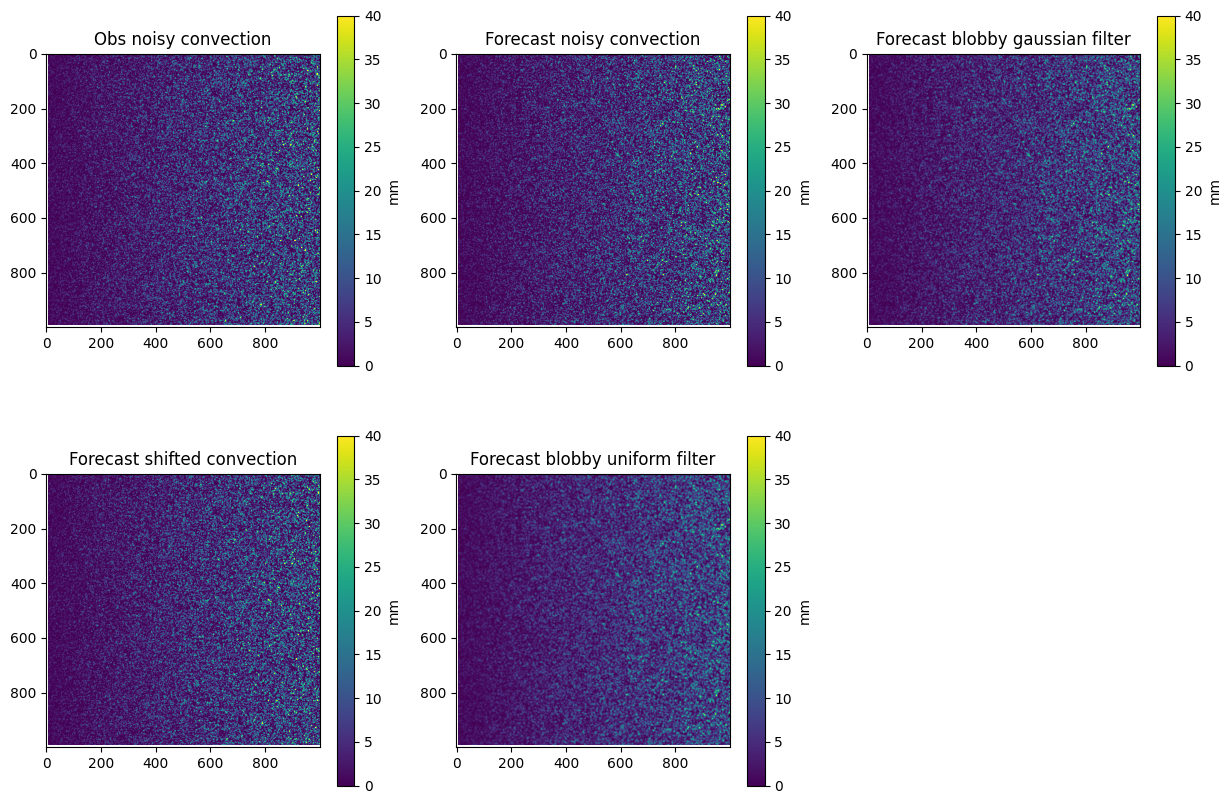

In [20]:
# Generate blobby convection observations
random_data = stats.skewnorm.rvs(a=0, scale=4, size=(Y_LEN, X_LEN)) * 10
random_data = random_data * np.linspace(0.25, 2, Y_LEN)
smoothed_data = gaussian_filter(random_data, sigma=1).clip(min=0)
obs_convection_blobs = xr.DataArray(smoothed_data, dims=["y", "x"])

# Generate perfect forecast that is offset by 5 in x and -5 in y
fcst = obs_convection_blobs.copy()
fcst_shifted = fcst.shift(x=5, y=-5)
fcst_shifted

# Generate blobby convection forecasts
random_data = stats.skewnorm.rvs(a=0, scale=4, size=(Y_LEN, X_LEN)) * 10
random_data = random_data * np.linspace(0.25, 2, Y_LEN)
smoothed_data = gaussian_filter(random_data, sigma=1).clip(min=0)
fcst_convection_blobs = xr.DataArray(smoothed_data, dims=["y", "x"])


fcst_blobby_uniform_filter = xr.apply_ufunc(
    uniform_filter, fcst_convection_blobs, kwargs=dict(size=NEIGHBORHOOD)
)
fcst_blobby_gaussian_filter = xr.apply_ufunc(
    gaussian_filter, fcst_convection_blobs, kwargs=dict(sigma=1)
)

(
    obs_convection_blobs,
    fcst_shifted,
    fcst_convection_blobs,
    fcst_blobby_uniform_filter,
    fcst_blobby_gaussian_filter,
) = broadcast_and_match_nan(
    obs_convection_blobs,
    fcst_shifted,
    fcst_convection_blobs,
    fcst_blobby_uniform_filter,
    fcst_blobby_gaussian_filter,
)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot obs_convection
im1 = axs[0, 0].imshow(obs_convection_blobs, vmin=0, vmax=BLOB_CONVECTION_VMAX)
axs[0, 0].set_title("Obs noisy convection")

# Plot fcst_convection
im2 = axs[0, 1].imshow(fcst_convection_blobs, vmin=0, vmax=BLOB_CONVECTION_VMAX)
axs[0, 1].set_title("Forecast noisy convection")

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0], label="mm")
fig.colorbar(im2, ax=axs[0, 1], label="mm")

# Plot fcst_shifted
im3 = axs[1, 0].imshow(fcst_shifted, vmin=0, vmax=BLOB_CONVECTION_VMAX)
axs[1, 0].set_title("Forecast shifted convection")

# Add colorbar
fig.colorbar(im3, ax=axs[1, 0], label="mm")

# Plot fcst_blobby_uniform_filter
im4 = axs[1, 1].imshow(fcst_blobby_uniform_filter, vmin=0, vmax=BLOB_CONVECTION_VMAX)
axs[1, 1].set_title("Forecast blobby uniform filter")

# Add colorbar
fig.colorbar(im4, ax=axs[1, 1], label="mm")

# Plot fcst_blobby_gaussian_filter
im5 = axs[0, 2].imshow(fcst_blobby_gaussian_filter, vmin=0, vmax=BLOB_CONVECTION_VMAX)
axs[0, 2].set_title("Forecast blobby gaussian filter")

# Add colorbar
fig.colorbar(im5, ax=axs[0, 2], label="mm")
# Hide the missing subplot
axs[1, 2].axis("off")
plt.show()

In [21]:
# Create ensembles
fcst_blobs_ens = create_neighourhood_ensemble(fcst_convection_blobs, NEIGHBORHOOD)
fcst_shifted_ens = create_neighourhood_ensemble(fcst_shifted, NEIGHBORHOOD)
fcst_blobby_uniform_filter_ens = create_neighourhood_ensemble(
    fcst_blobby_uniform_filter, NEIGHBORHOOD
)
fcst_blobby_gaussian_filter_ens = create_neighourhood_ensemble(
    fcst_blobby_gaussian_filter, NEIGHBORHOOD
)

In [22]:
# Calculate CRPS
crps_blobs = crps_for_ensemble(
    fcst_blobs_ens, obs_convection_blobs, ensemble_member_dim="ens_mem"
).values
crps_shifted = crps_for_ensemble(
    fcst_shifted_ens, obs_convection_blobs, ensemble_member_dim="ens_mem"
).values
crps_blobby_uniform_filter = crps_for_ensemble(
    fcst_blobby_uniform_filter_ens, obs_convection_blobs, ensemble_member_dim="ens_mem"
).values
crps_blobby_gaussian_filter = crps_for_ensemble(
    fcst_blobby_gaussian_filter_ens, obs_convection_blobs, ensemble_member_dim="ens_mem"
).values
# Calculate MSE
mse_blobs = mse(fcst_convection_blobs, obs_convection_blobs).values
mse_shifted = mse(fcst_shifted, obs_convection_blobs).values
mse_blobby_uniform_filter = mse(fcst_blobby_uniform_filter, obs_convection_blobs).values
mse_blobby_gaussian_filter = mse(
    fcst_blobby_gaussian_filter, obs_convection_blobs
).values
print(f"CRPS for blobs: {crps_blobs}")
print(f"CRPS for shifted: {crps_shifted}")
print(f"CRPS for blobby uniform filter: {crps_blobby_uniform_filter}")
print(f"CRPS for blobby gaussian filter: {crps_blobby_gaussian_filter}")
print(f"MSE for blobs: {mse_blobs}")
print(f"MSE for shifted: {mse_shifted}")
print(f"MSE for blobby uniform filter: {mse_blobby_uniform_filter}")
print(f"MSE for blobby gaussian filter: {mse_blobby_gaussian_filter}")

CRPS for blobs: 4.333732391413144
CRPS for shifted: 4.3201447134312145
CRPS for blobby uniform filter: 5.078470267263698
CRPS for blobby gaussian filter: 4.755099699188701
MSE for blobs: 132.89744463292783
MSE for shifted: 131.48969462539296
MSE for blobby uniform filter: 84.32069244904868
MSE for blobby gaussian filter: 96.18324388433635
